In [31]:
import os
os.environ["KERAS_BACKEND"] = "jax" # This can be either JAX, tensorflow, or torch. (tensorflow by default)

In [32]:
import keras
from keras import ops
print(f"Keras backend: {keras.backend.backend()}")

Keras backend: jax


In [33]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from pennylane_keras_layer import KerasCircuitLayer

## Setting up the target dataset

Similiar to the [fourier series demo]((https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series) mentioned in the introduction, we first define a (classical) target function which will be used as a “ground truth” that the quantum model has to fit. The target function is constructed as a Fourier series of a specific degree.

In [5]:
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j] * degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency


def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx + 1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

Plotting the function

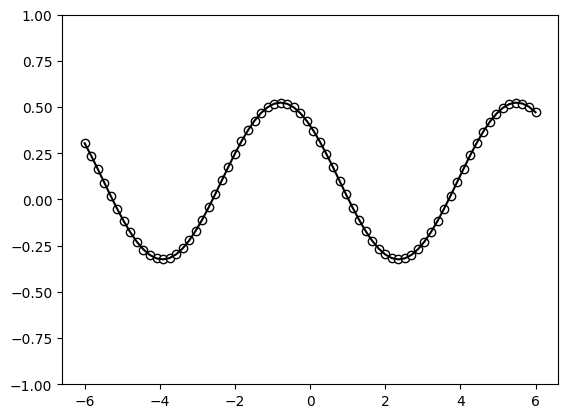

In [6]:
x = np.linspace(-6, 6, 70)
target_y = np.array([target_function(x_) for x_ in x])

plt.plot(x, target_y, c="black")
plt.scatter(x, target_y, facecolor="white", edgecolor="black")
plt.ylim(-1, 1)
plt.show()

## Define the circuit

In [7]:
dev = qml.device("default.qubit", wires=1) # Define the device for circuit execution
scaling = 1.0

In [8]:
def S(x):
    """Data-encoding circuit block."""
    qml.RX(scaling * x, wires=0)


def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)


@qml.qnode(dev)
def serial_quantum_model(weights, x):

    for theta in weights[:-1]:
        W(theta)
        S(x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))

(<Figure size 800x200 with 1 Axes>, <Axes: >)

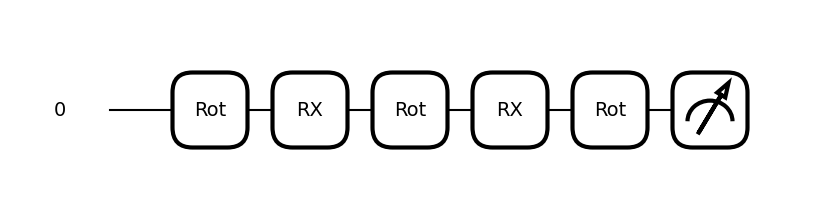

In [9]:
layers = 2  
weights = (
    2 * np.pi * np.random.random(size=(layers + 1, 3))
)  # some random initial weights
qml.draw_mpl(serial_quantum_model)(weights,1)

Plotting the circuit output we get

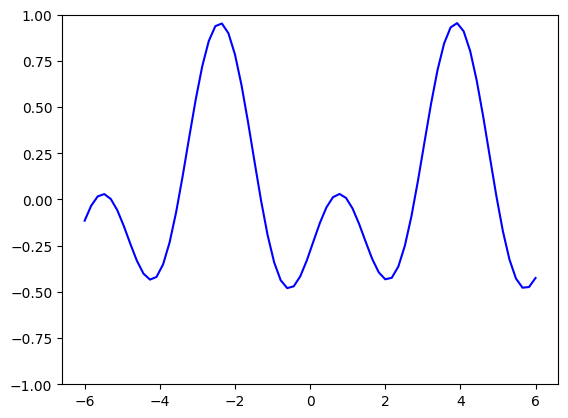

In [10]:
x = np.linspace(-6, 6, 70)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c="blue")
plt.ylim(-1, 1)
plt.show()

In [24]:
keras_layer = KerasCircuitLayer(layers = layers,
                          scaling=1.0,
                          circ_backend="default.qubit",
                          num_wires=1,
                          name="QuantumLayer",
                          # Use the flag below to experiment with vectorized jax
                          # use_jax_python=True 
                         )

In [25]:
# Simple univariate input layer
inp = keras.layers.Input(shape=(1,))
out = keras_layer(inp)
model = keras.models.Model(inputs=inp,outputs=out,name="QuantumModel")
model.summary()

Model: "QuantumModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ QuantumLayer                    │ (None, 1)              │             9 │
│ (KerasCircuitLayer)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

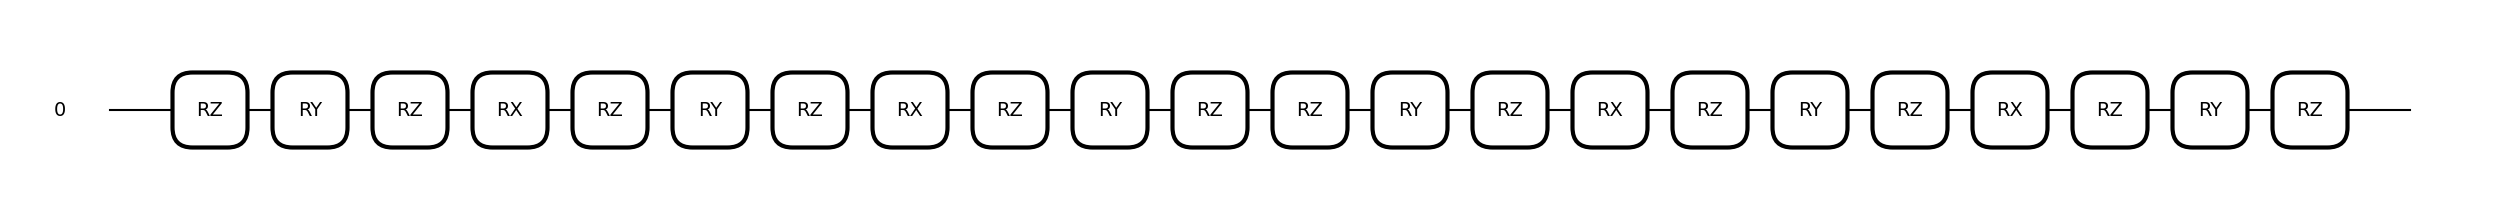

In [27]:
keras_layer.draw_qnode(level='top')

## Model Training

In [36]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.03),
loss = keras.losses.mean_squared_error,run_eagerly=False,jit_compile=True)

In [37]:
model.fit(x=x,y=target_y,
          epochs=30)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0027
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0013    
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.9826e-04
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.9707e-04
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.8676e-04
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.9463e-04
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 9.0182e-04
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.1260e-04
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.4914e-04
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.5622e-04
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.7599e-04
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 8.0657e-04
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.1760e-04
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.6870e-04
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/s